# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


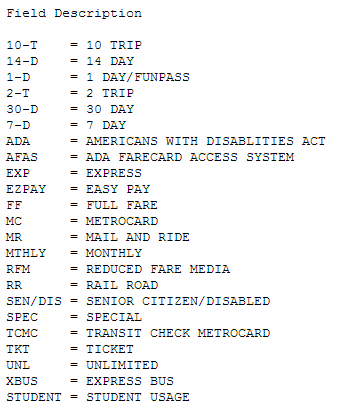

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [61]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [4]:
mta_data = np.load("MTA_Fare.npy")
mta_data.shape

(600, 23, 194)

In [17]:
date = pd.date_range(start='05/24/2010', end='02/15/2014', freq='W')

In [18]:
date

DatetimeIndex(['2010-05-30', '2010-06-06', '2010-06-13', '2010-06-20',
               '2010-06-27', '2010-07-04', '2010-07-11', '2010-07-18',
               '2010-07-25', '2010-08-01',
               ...
               '2013-12-08', '2013-12-15', '2013-12-22', '2013-12-29',
               '2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [9]:
mta_data = mta_data.astype(float)
np.place(mta_data, mta_data < 0, np.nan)
mta_data.shape

(600, 23, 194)

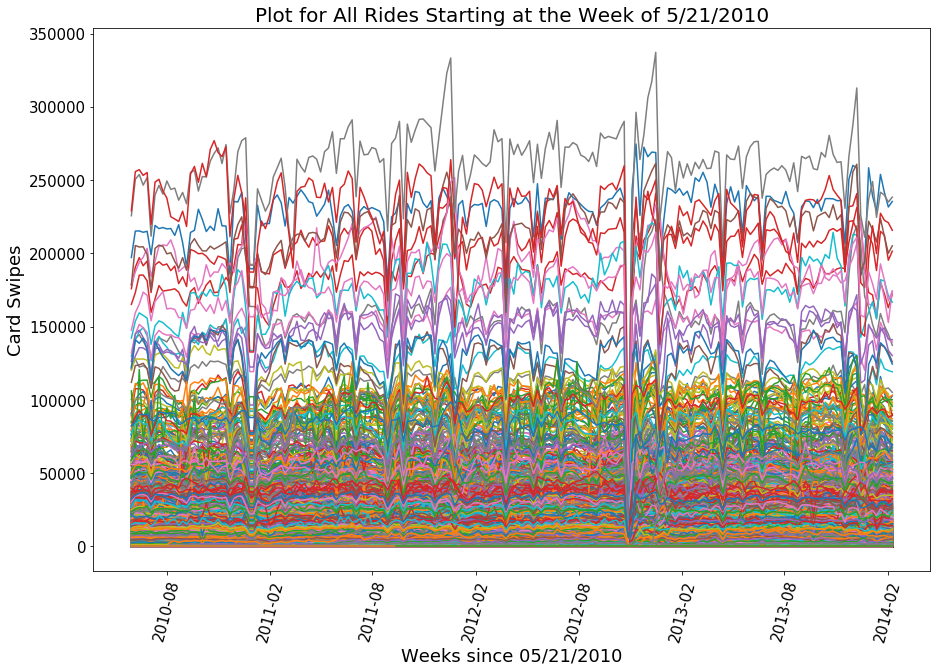

In [19]:
pl.figure(figsize=(15,10))
for i in arange(len(mta_data)):
    for j in arange(len(mta_data[i])):
        pl.plot(date, mta_data[i][j])
pl.xlabel('Weeks since 05/21/2010', fontsize = 18)
pl.ylabel('Card Swipes', fontsize = 18)
pl.xticks(rotation=75, fontsize=15)
pl.yticks(fontsize=15)
pl.title('Plot for All Rides Starting at the Week of 5/21/2010', fontsize = 20)

In [21]:
sum_station = np.nansum(mta_data, axis=0)
mean_station = np.nanmean(mta_data, axis=0)
sum_swipe = np.nansum(mta_data, axis=1)
mean_swipe = np.nanmean(mta_data, axis=1)
sum_total = np.nansum(sum_swipe, axis=0)

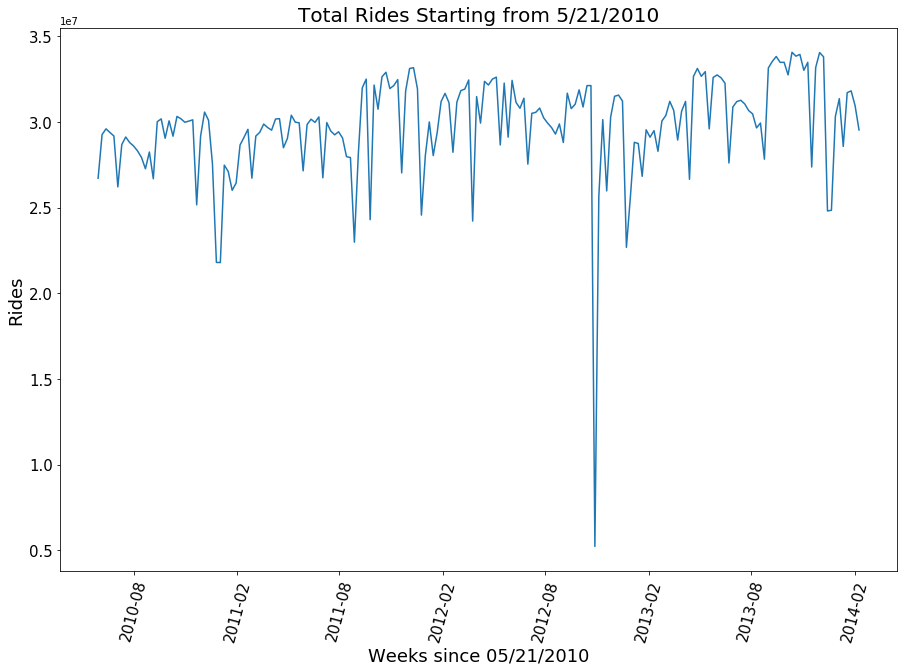

In [22]:
pl.figure(figsize=(15,10))
pl.plot(date, sum_total)
pl.xlabel('Weeks since 05/21/2010', fontsize=18)
pl.ylabel('Rides', fontsize=18)
pl.xticks(rotation=75, fontsize=15)
pl.yticks(fontsize=15)
pl.title('Total Rides Starting from 5/21/2010', fontsize=20)

### Fig 1. Figure shows the total number of rides between May, 2010 and Feb, 2014. It can be seen that there is a steep decrease in total rides somewhere between Aug, 2012 and Feb, 2013. This could be an indication of a major calamity 

In [23]:
mean_total = np.nanmean(sum_total)
sd_total = np.nanstd(sum_total)
threshold = [mean_total + 3 * sd_total, mean_total - 3 * sd_total]
print ("Average Number of Rides: {:}".format(int(mean_total)))
print ("std of Number of Rides: {:}".format(int(sd_total)))
print ("3-Sigma Thresholds {:.2f} {:.2f}".format(*threshold))

Average Number of Rides: 29781349
std of Number of Rides: 2983960
3-Sigma Thresholds 38733231.14 20829468.61


In [25]:
outlier = date[((sum_total > threshold[0]) | (sum_total < threshold[1]))]
print(outlier.values[0])

2012-10-28T00:00:00.000000000


### The outlier event happened on 28th Oct, 2012. The marks the event of Sandy, a category 2 hurricane that stuck the east coast

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [35]:
card = np.array(['10T', '14D', '1D', '2T', '30D', '7D', 'ADA', 'AFAS',
                     'EXP','EZ','FF','MC','MR','MTHLY','RFM','RR','SEN',
                     'SPEC','TCMC','TKT','UNL','XBUS','STUD'])

df1 = pd.DataFrame()
for i in arange(len(card)):
    df1[card[i]] = mean_station[i]
df1['Date'] = pd.DataFrame(date)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


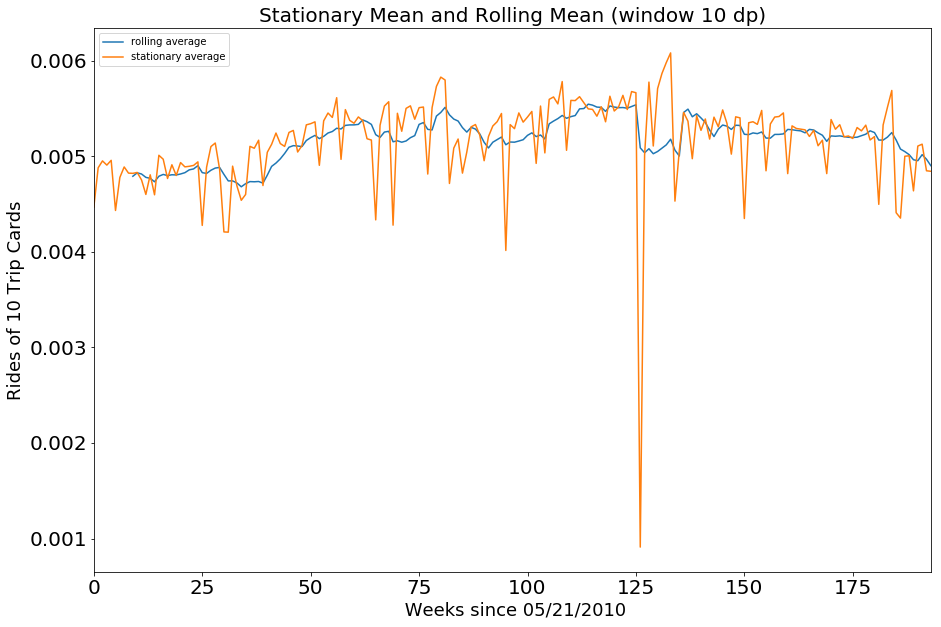

In [27]:
fig = pl.figure(figsize=(15,10))
ax = pd.rolling_mean(df1['10T']/df1['10T'].sum(), 10).plot(fontsize=20, label = "rolling average")
ax.set_title("Stationary Mean and Rolling Mean (window 10 dp)", fontsize=20)
pl.xlabel(' Weeks since 05/21/2010', fontsize = 18)
pl.ylabel('Rides of 10 Trip Cards', fontsize = 18)
ax.plot(df1['10T']/df1['10T'].sum(), label = "stationary average")
pl.legend(loc = 2)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  from ipykernel import kernelapp as app


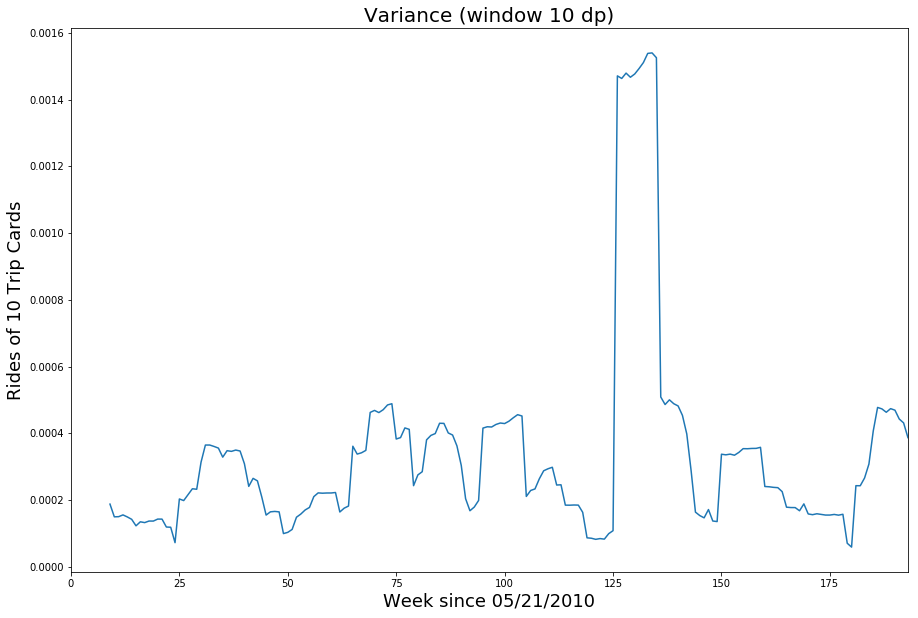

In [28]:
fig = pl.figure(figsize=(15,10))
ax = pd.rolling_std(df1['10T']/df1['10T'].sum(), 10).plot()
ax.set_title("Variance (window 10 dp)", fontsize=20)
pl.xlabel("Week since 05/21/2010", fontsize=18)
pl.ylabel("Rides of 10 Trip Cards", fontsize=18)

In [40]:
df1.drop(126, inplace = True) #removing outlier

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).std()


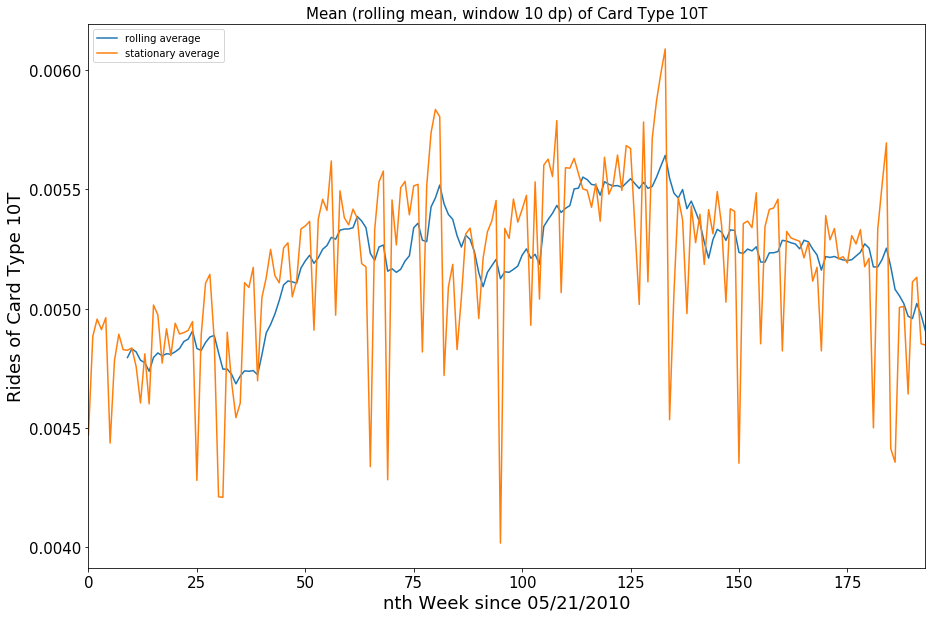

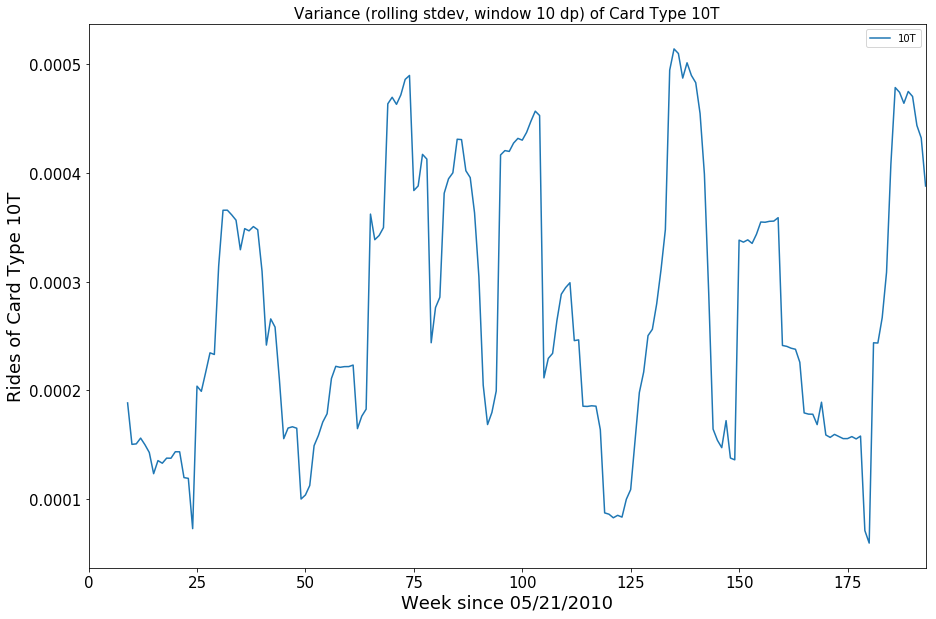

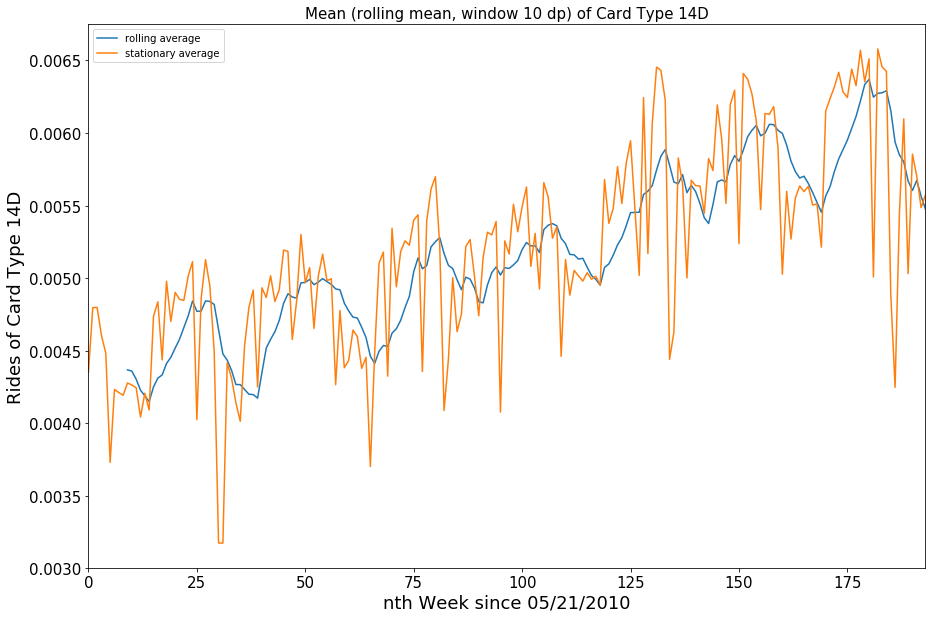

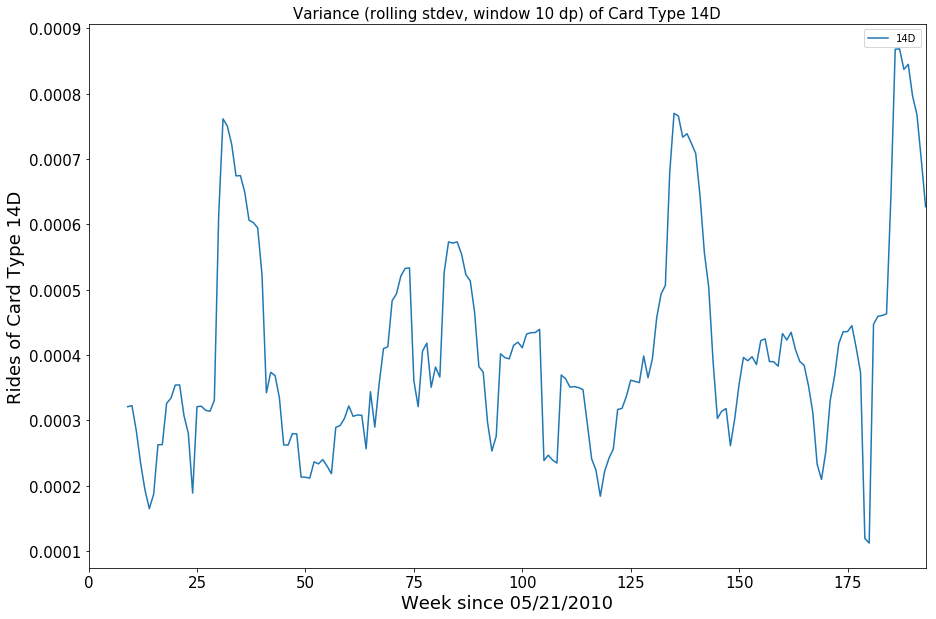

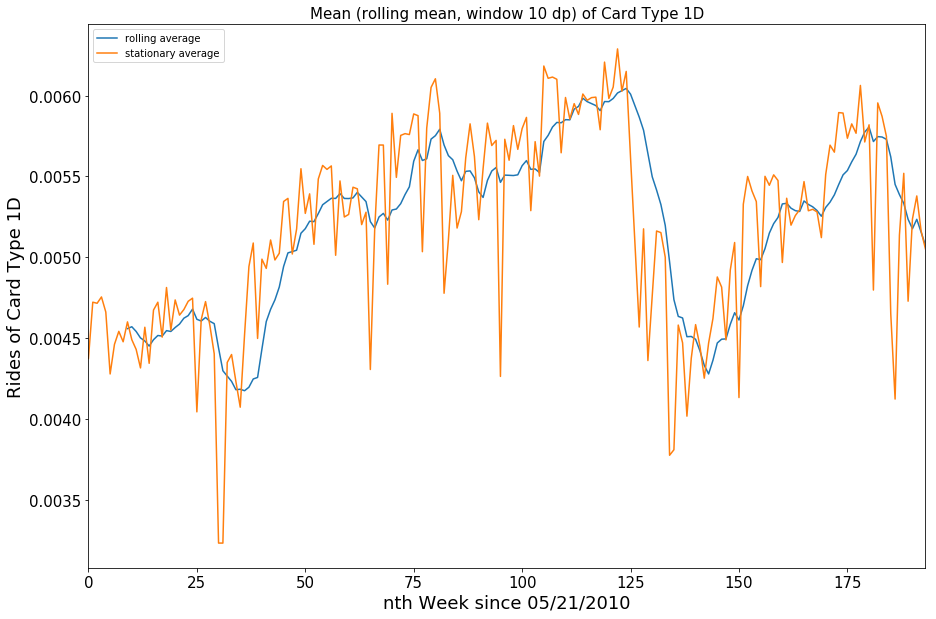

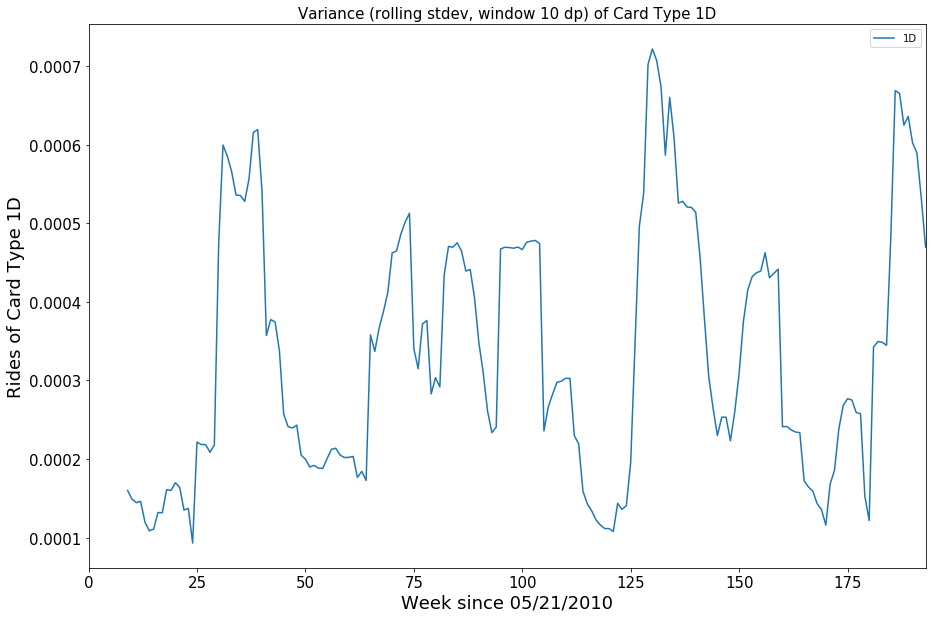

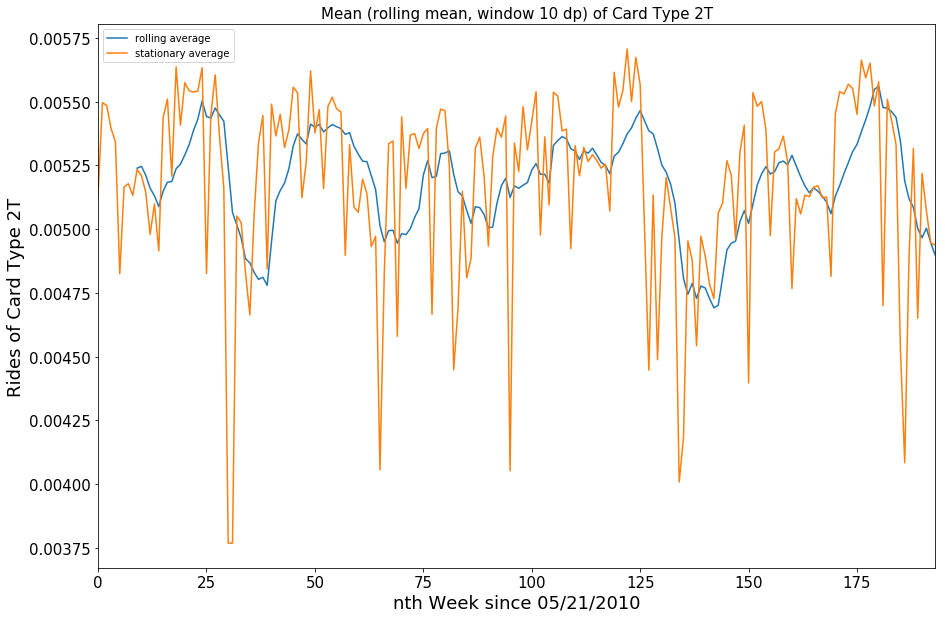

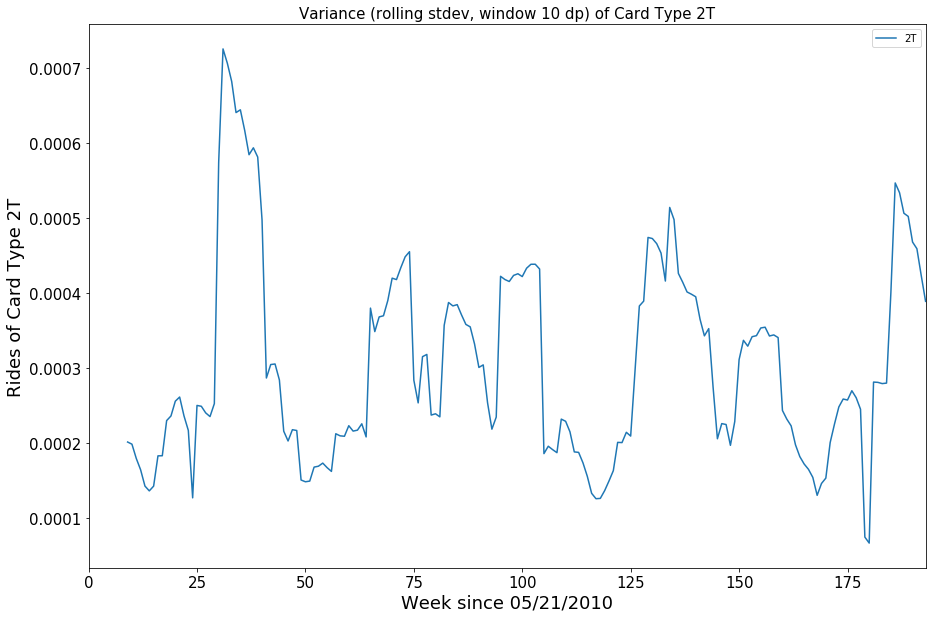

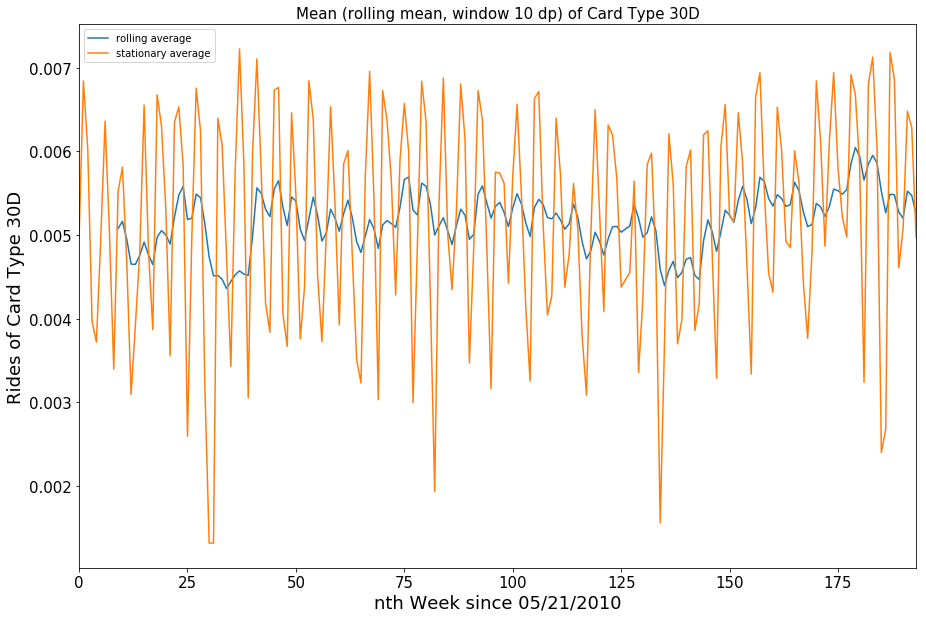

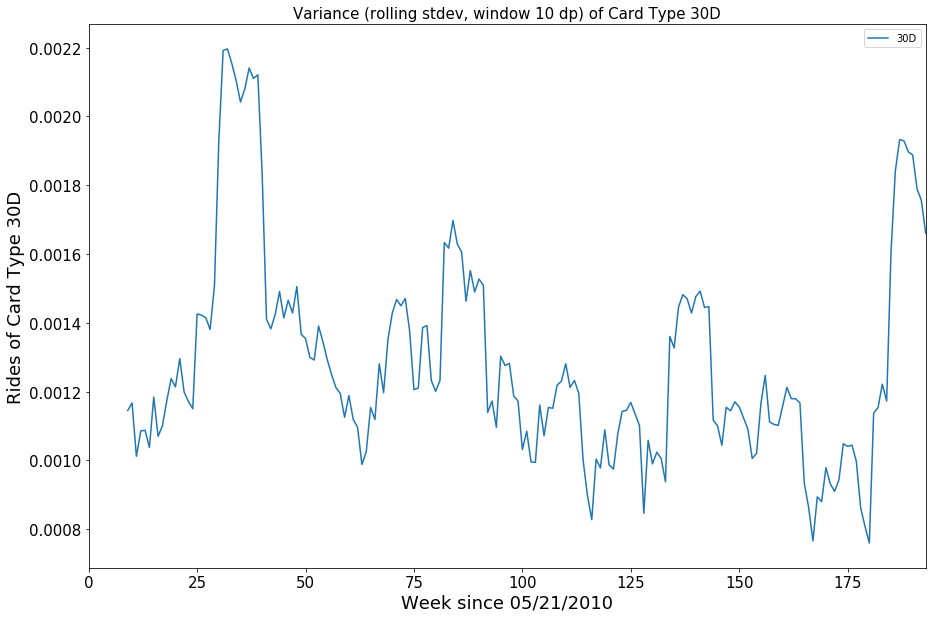

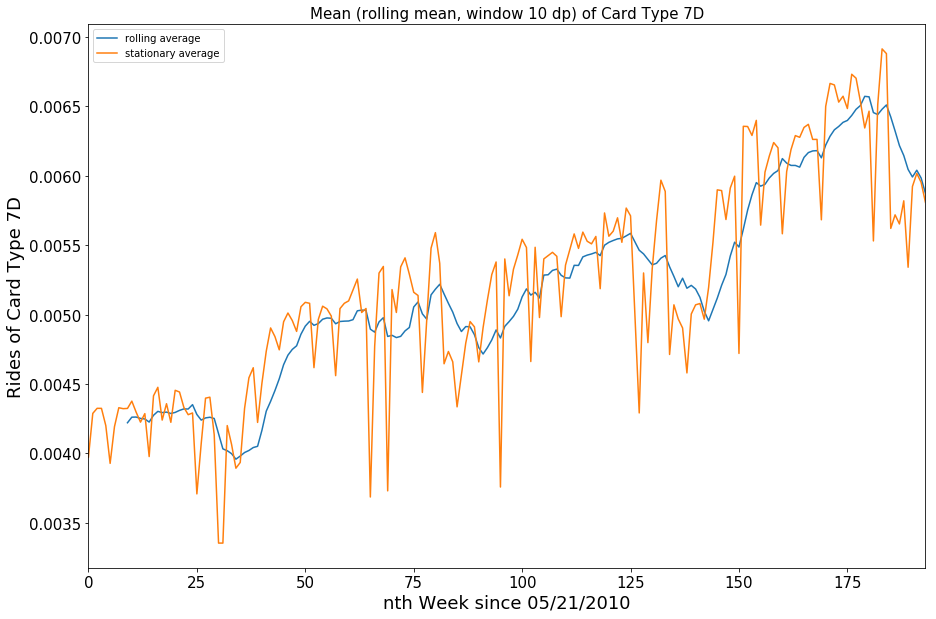

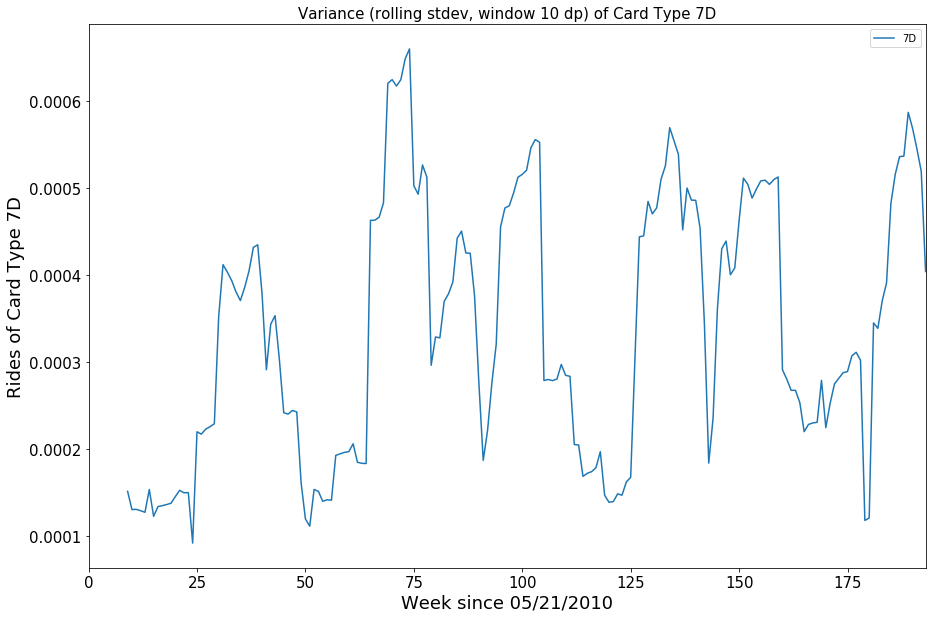

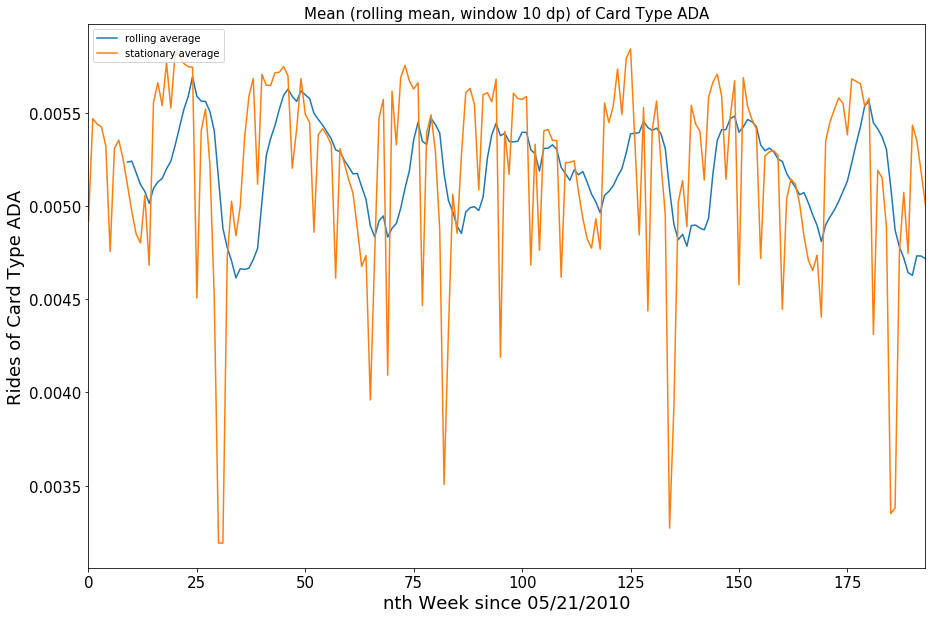

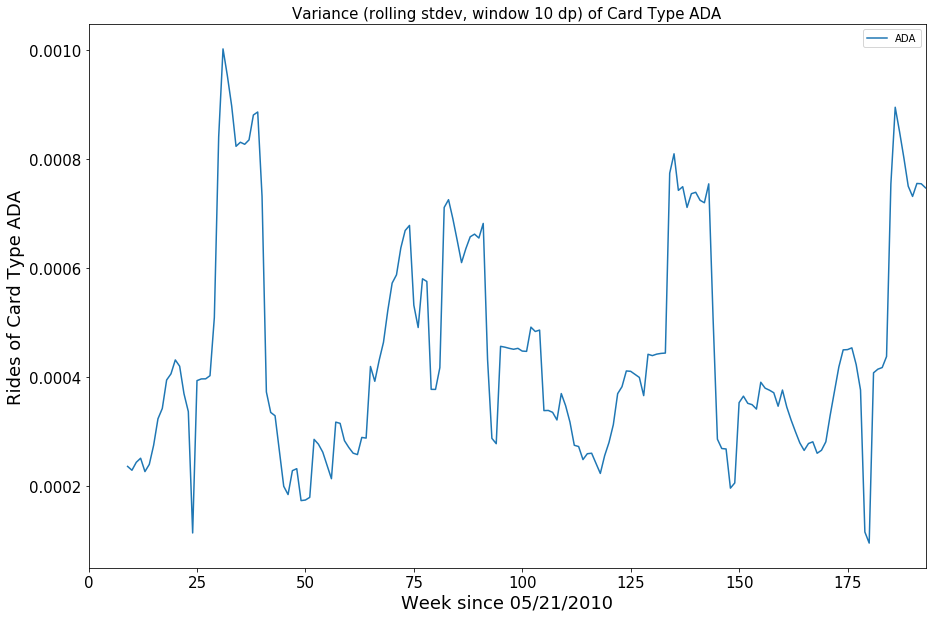

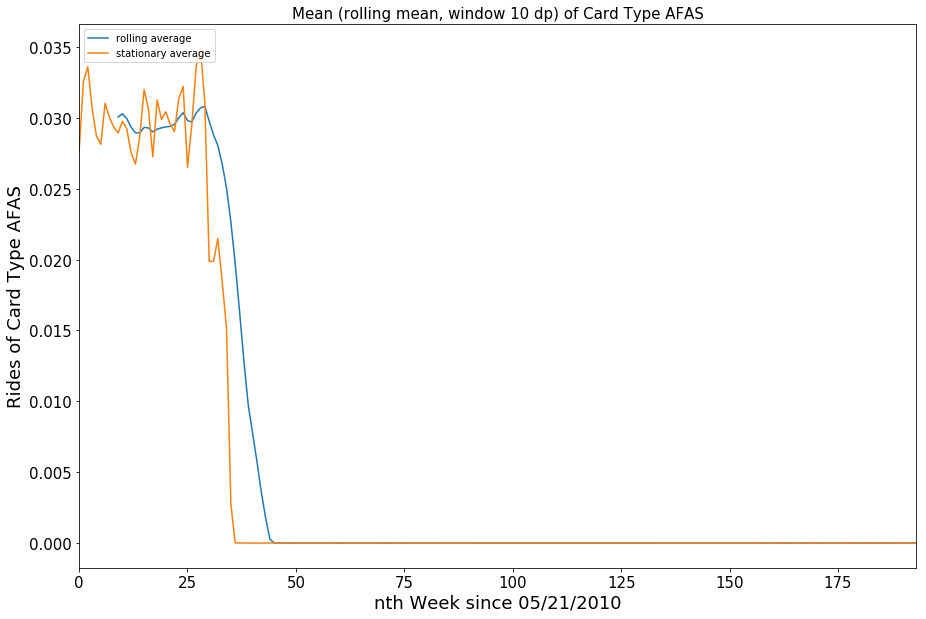

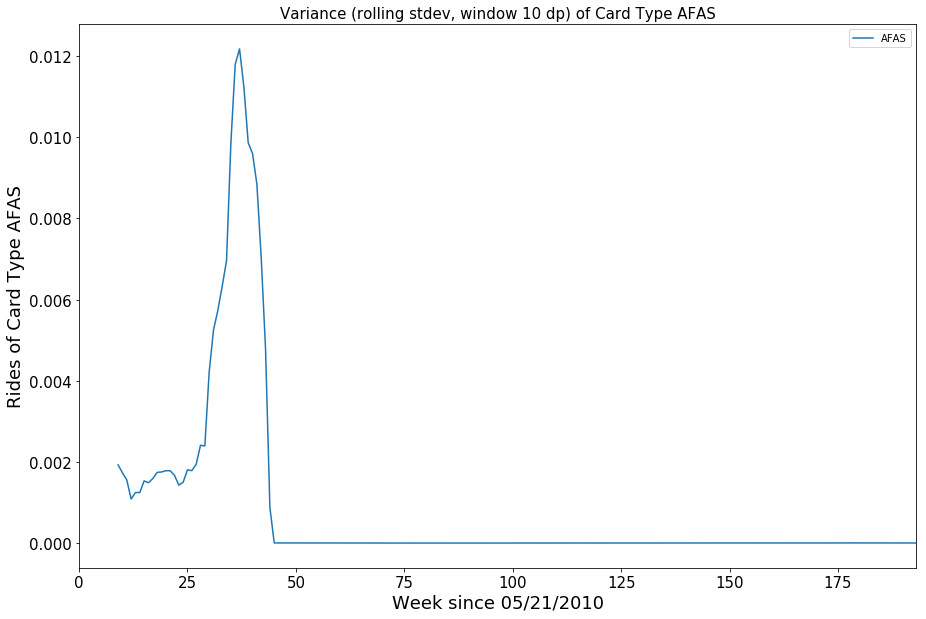

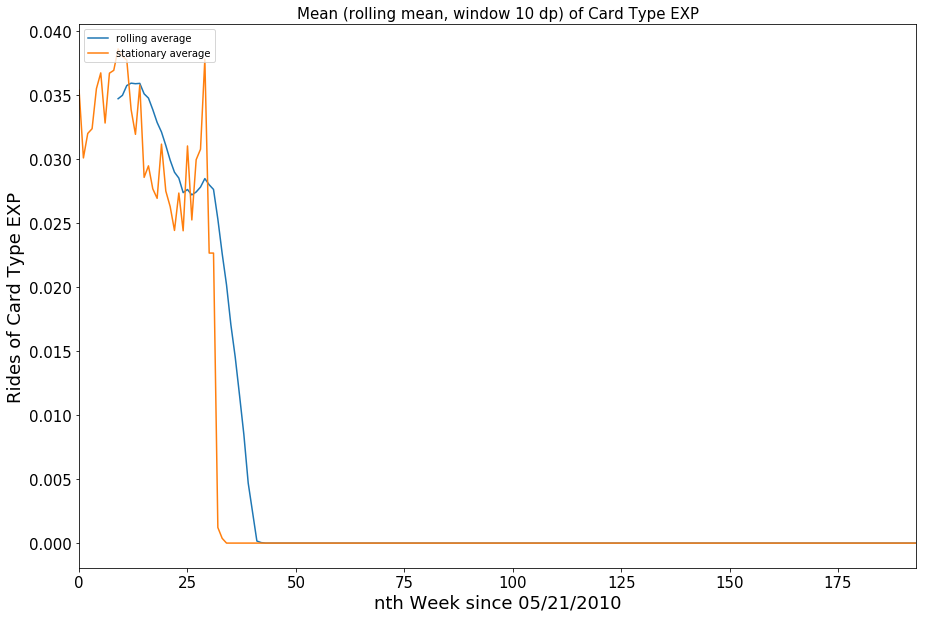

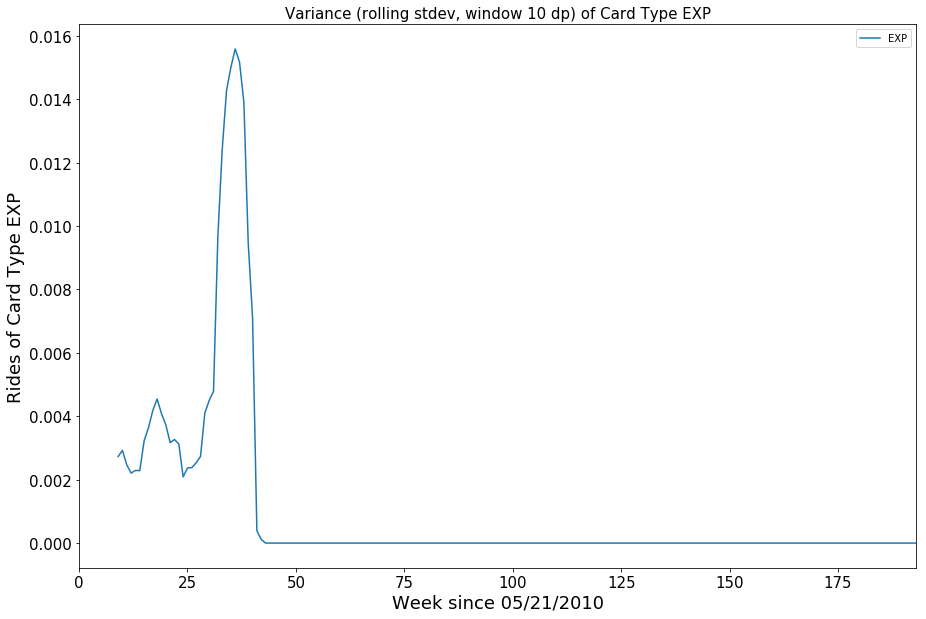

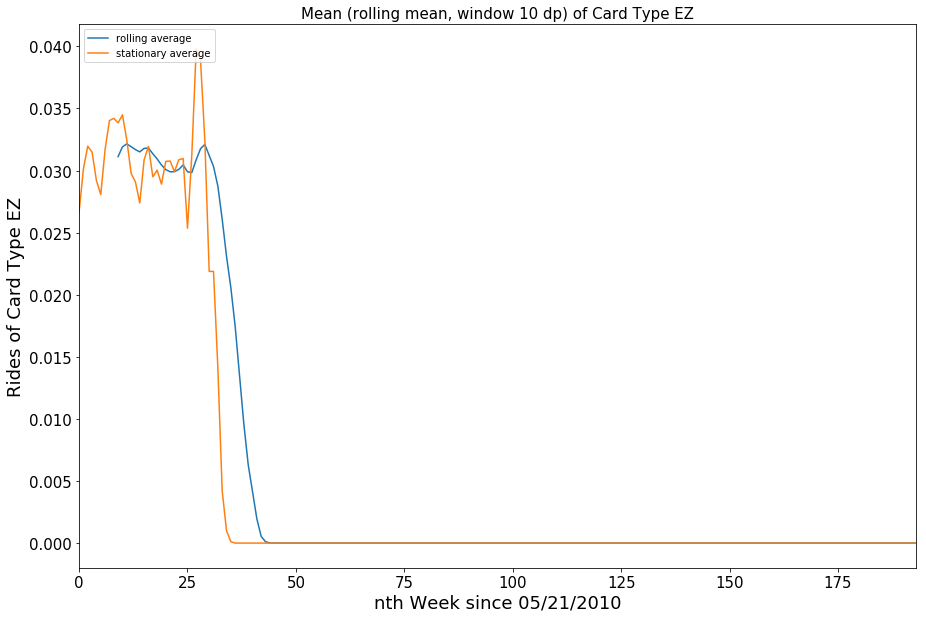

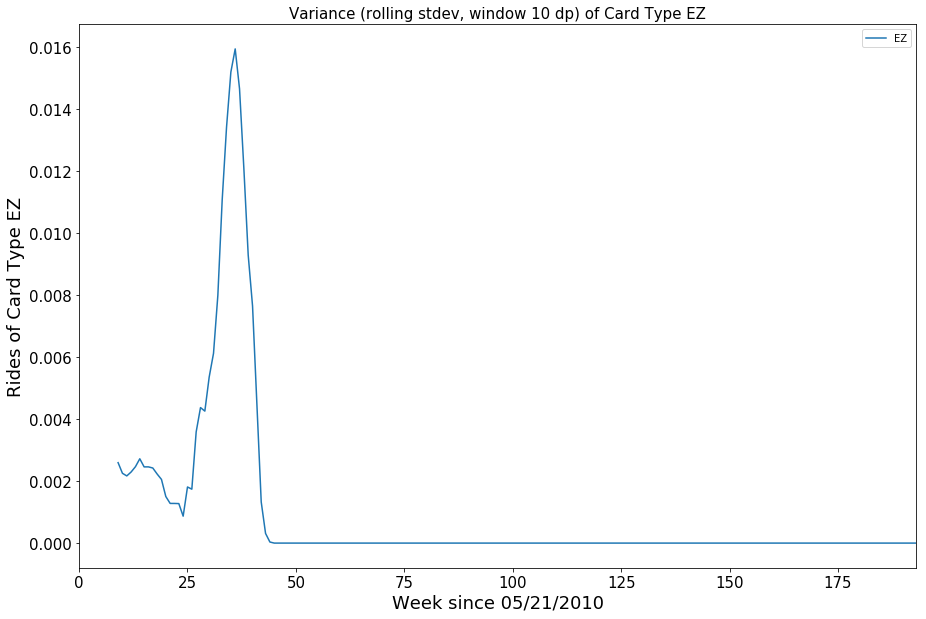

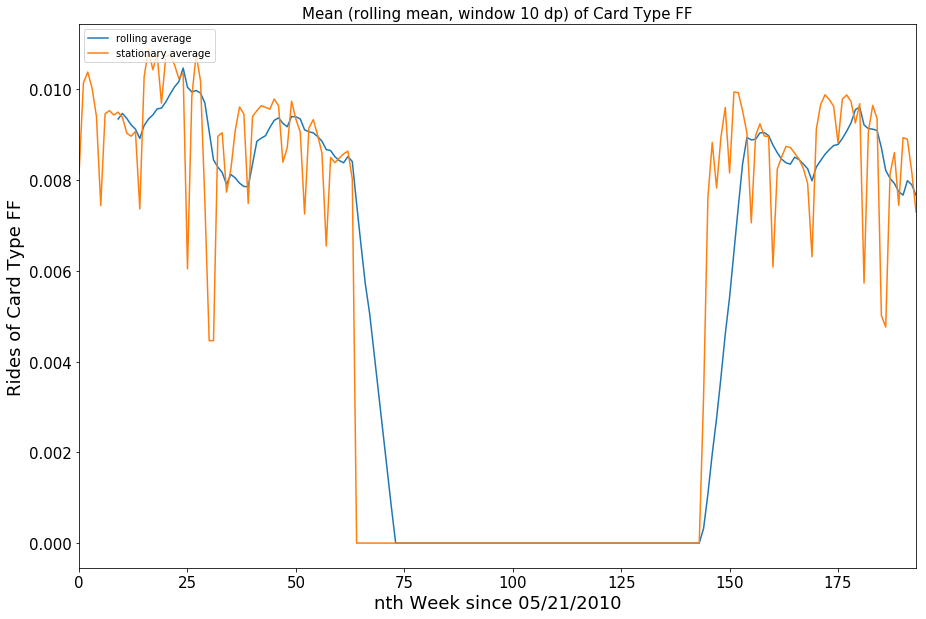

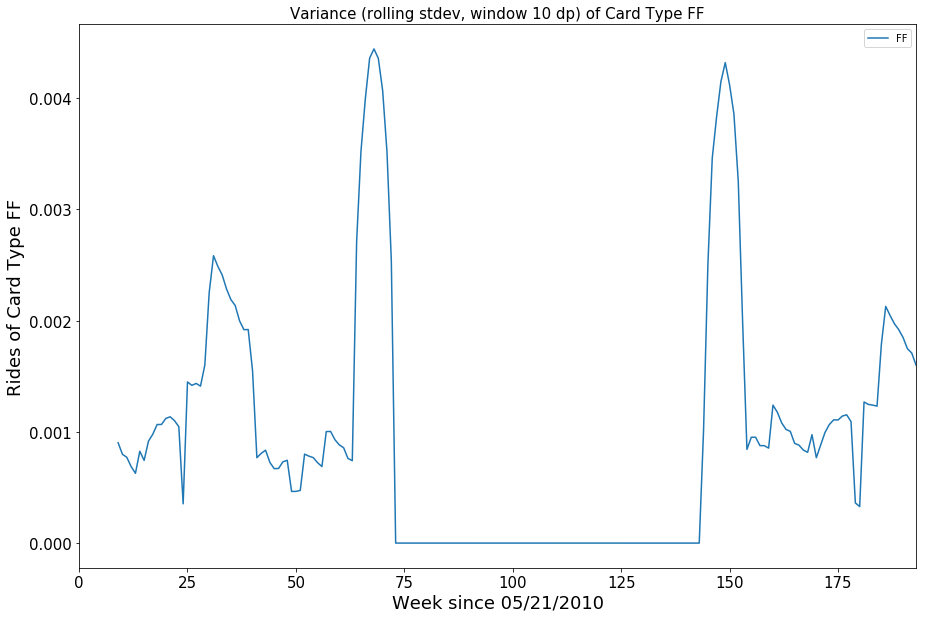

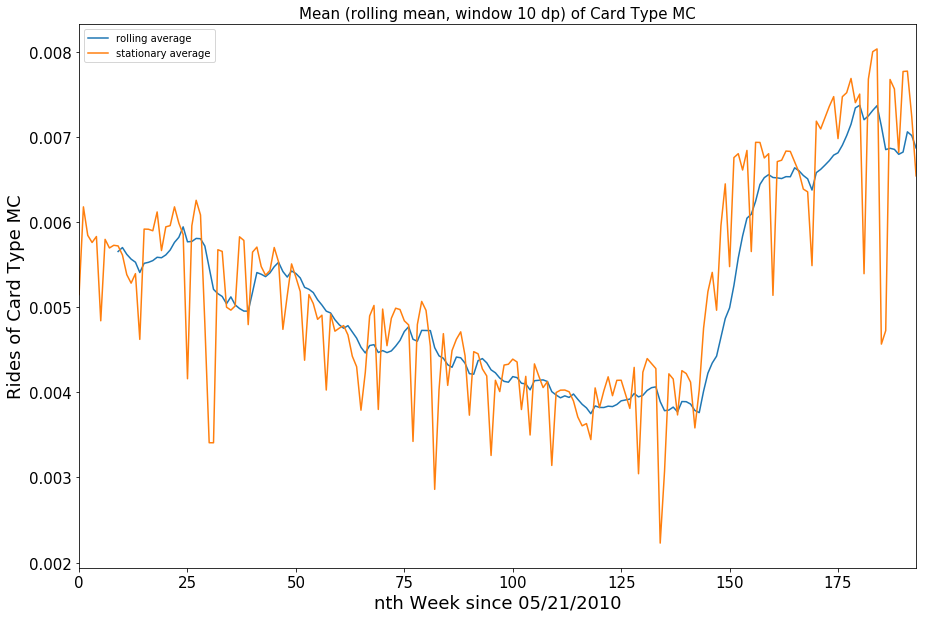

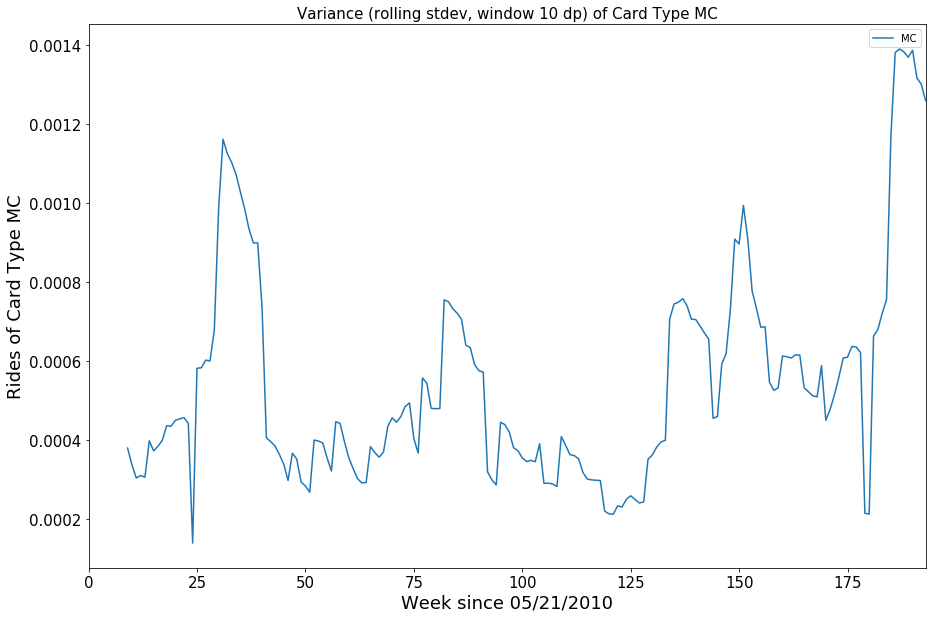

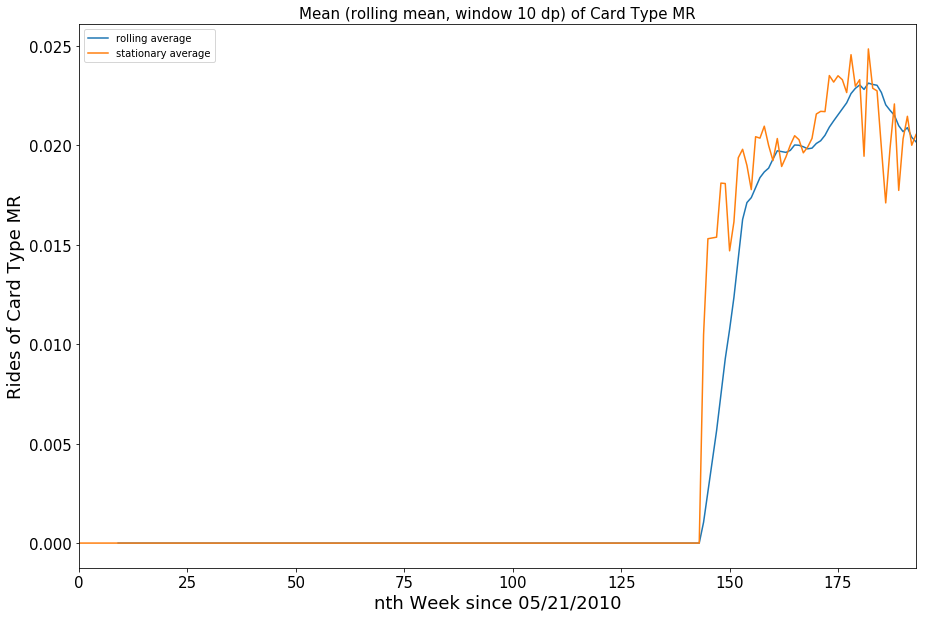

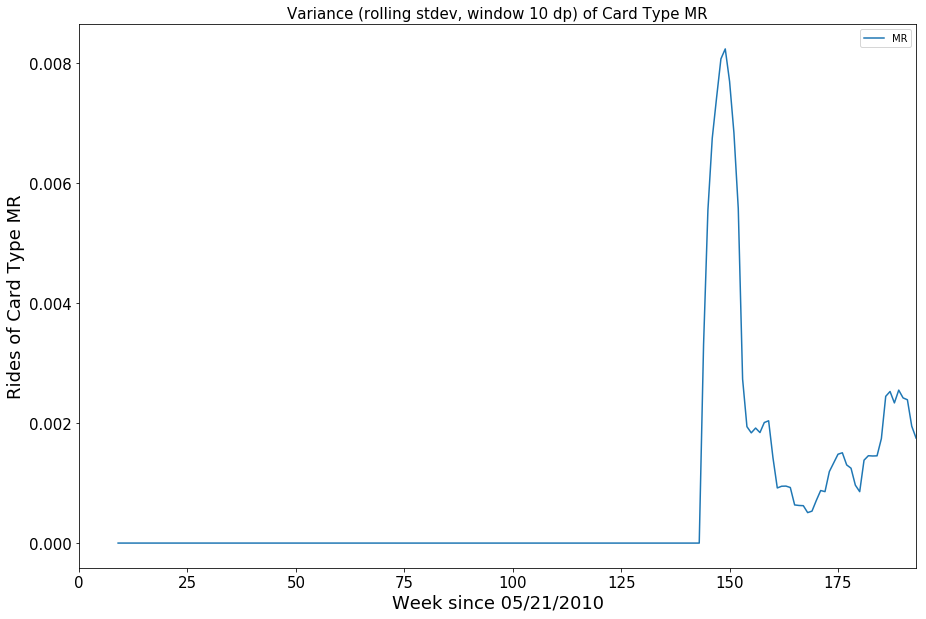

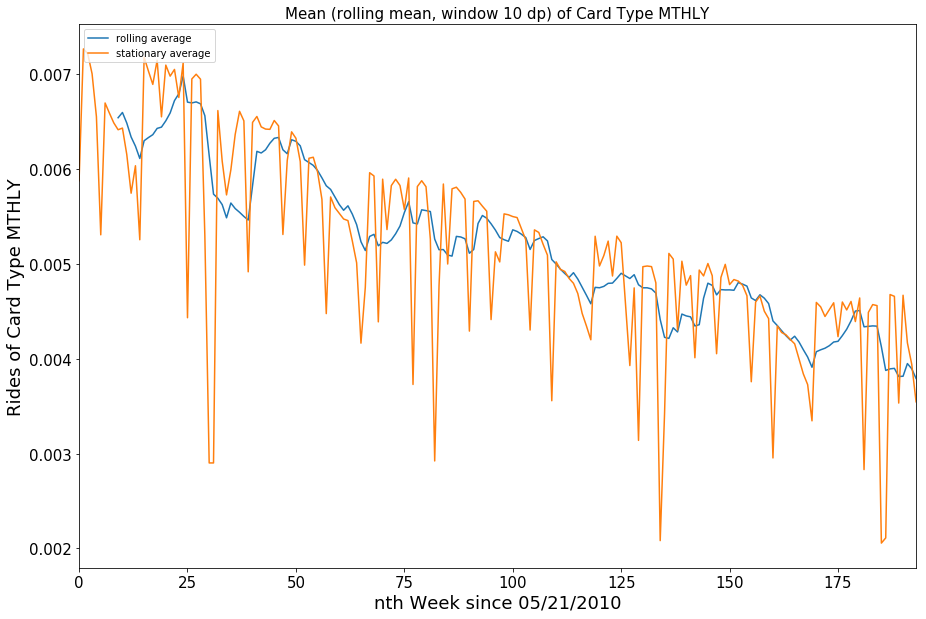

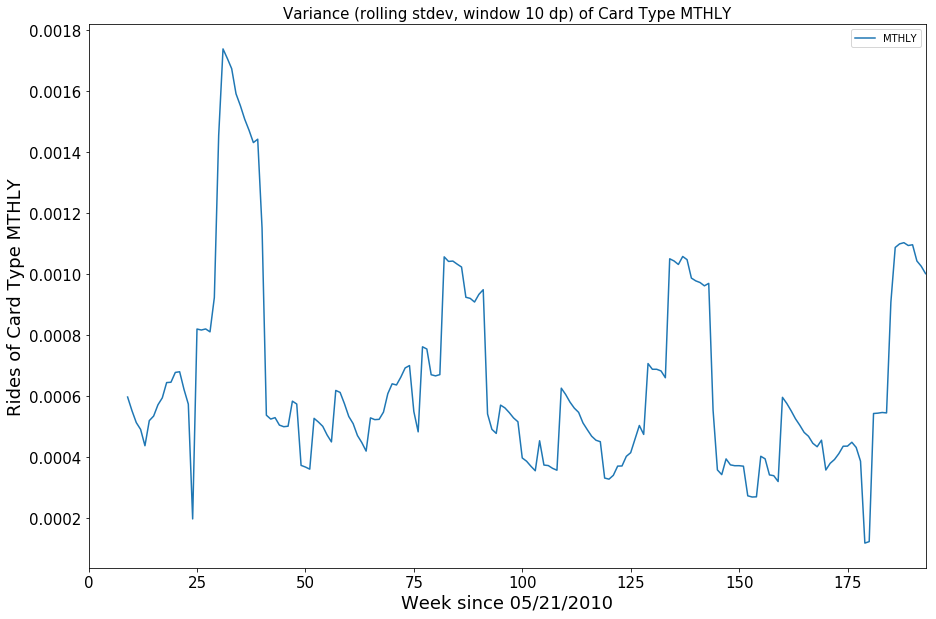

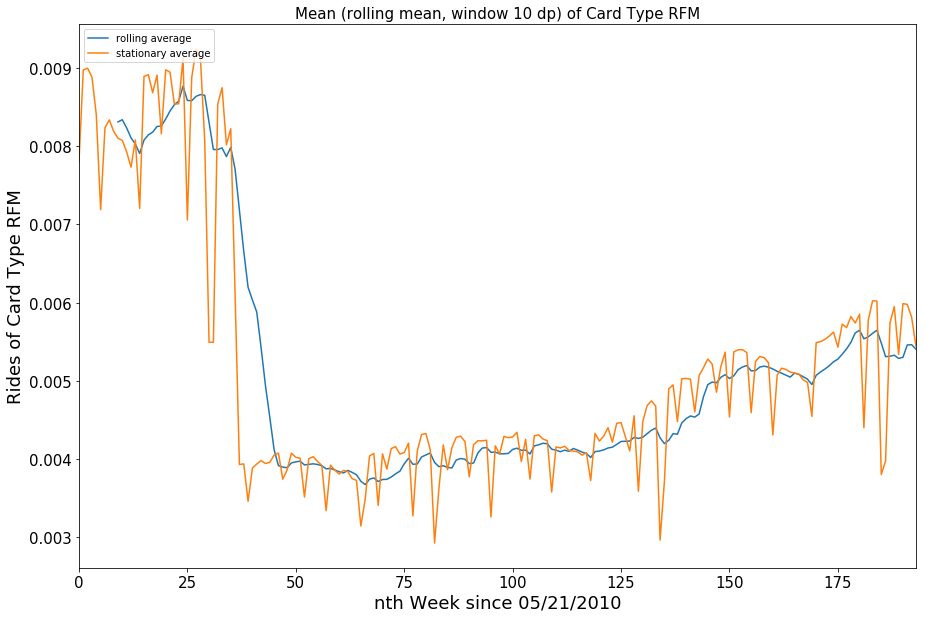

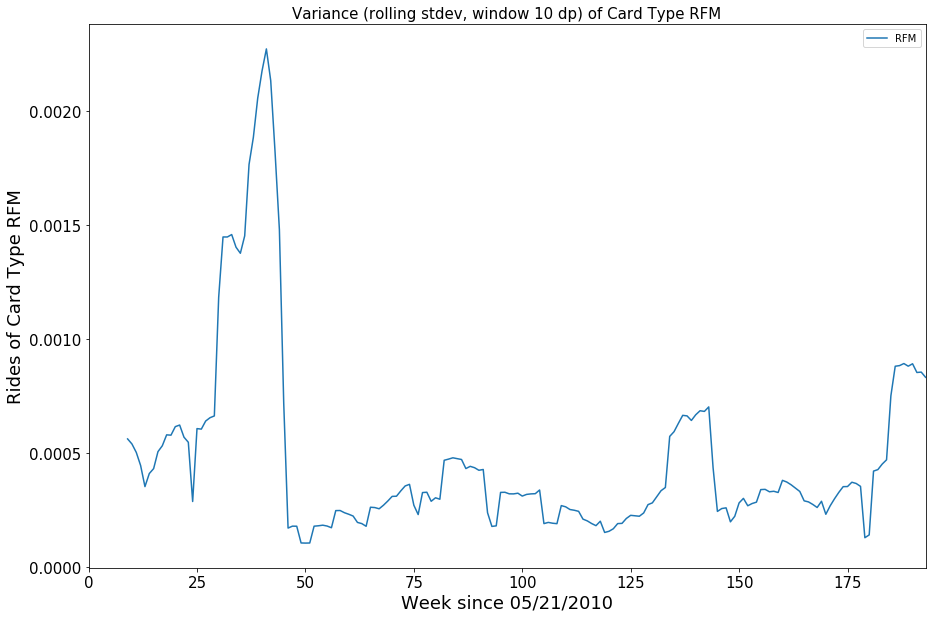

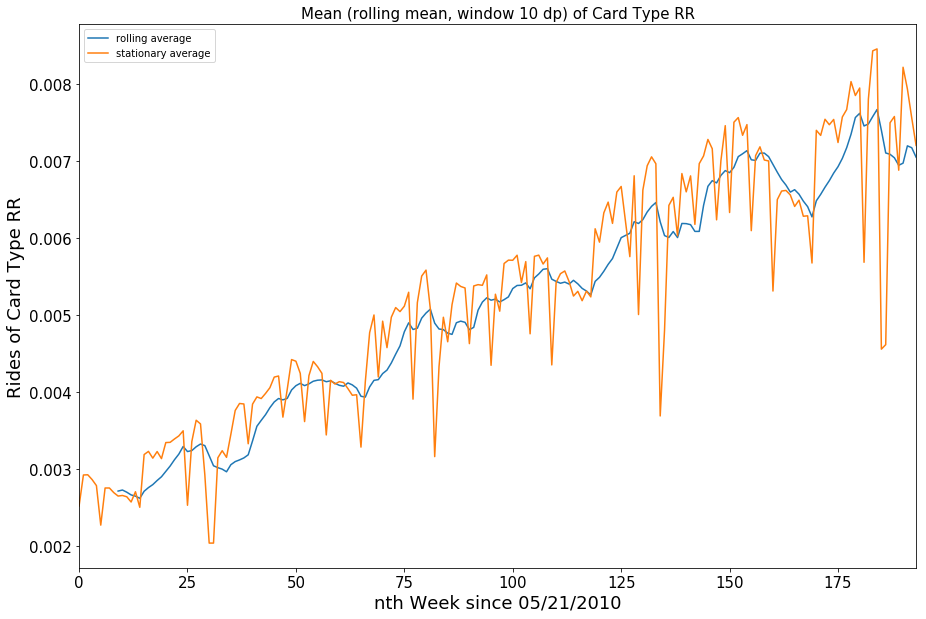

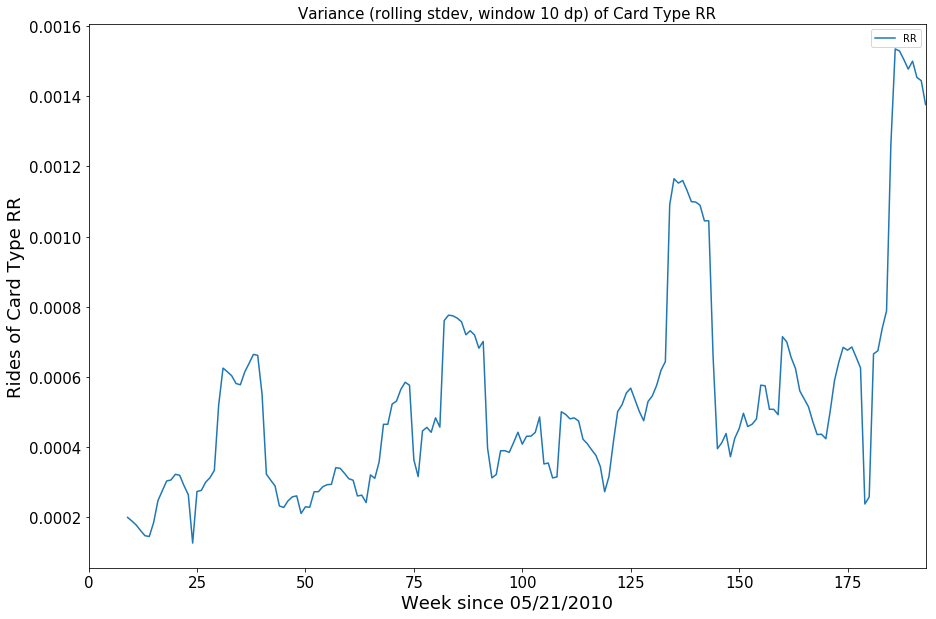

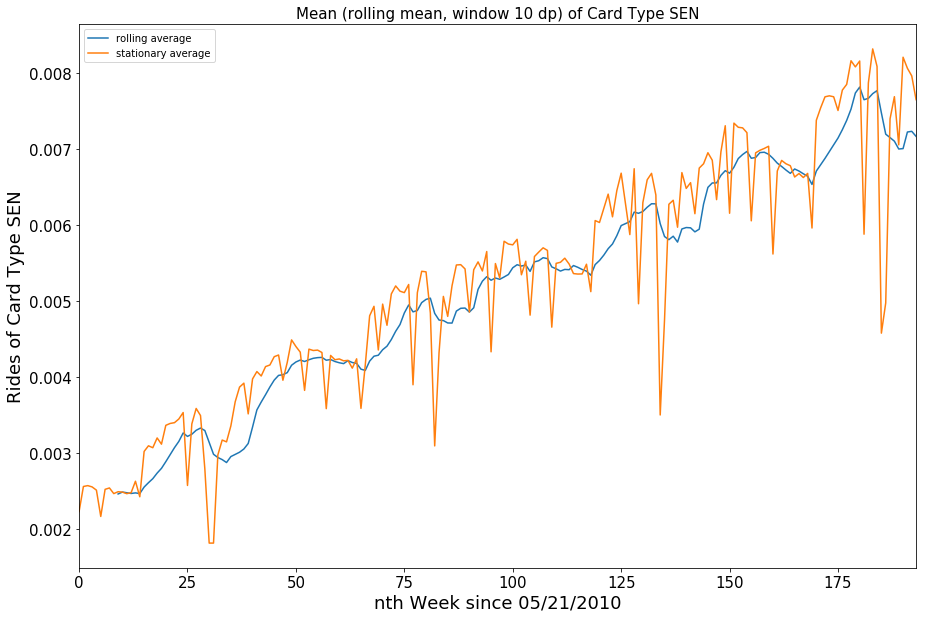

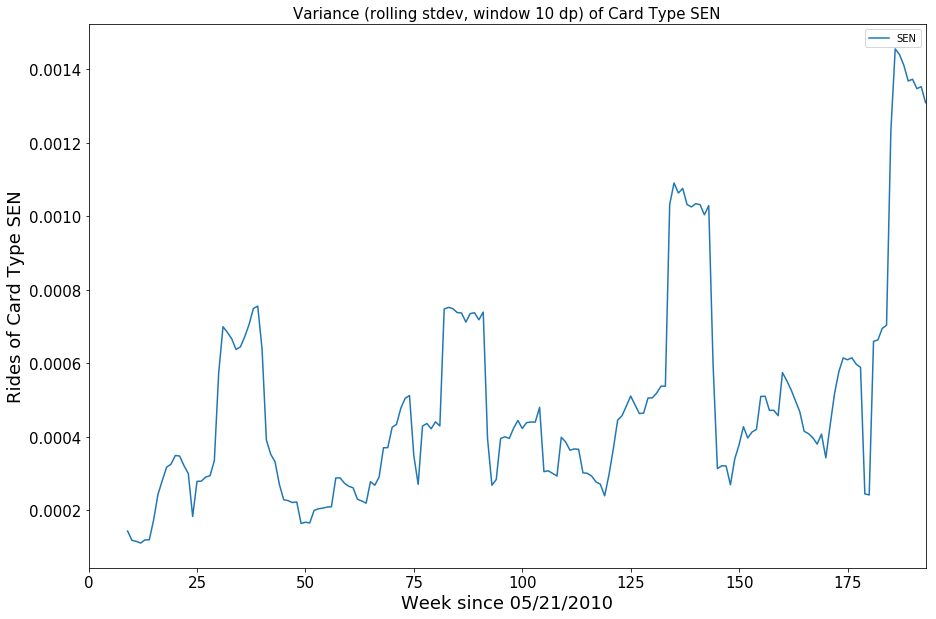

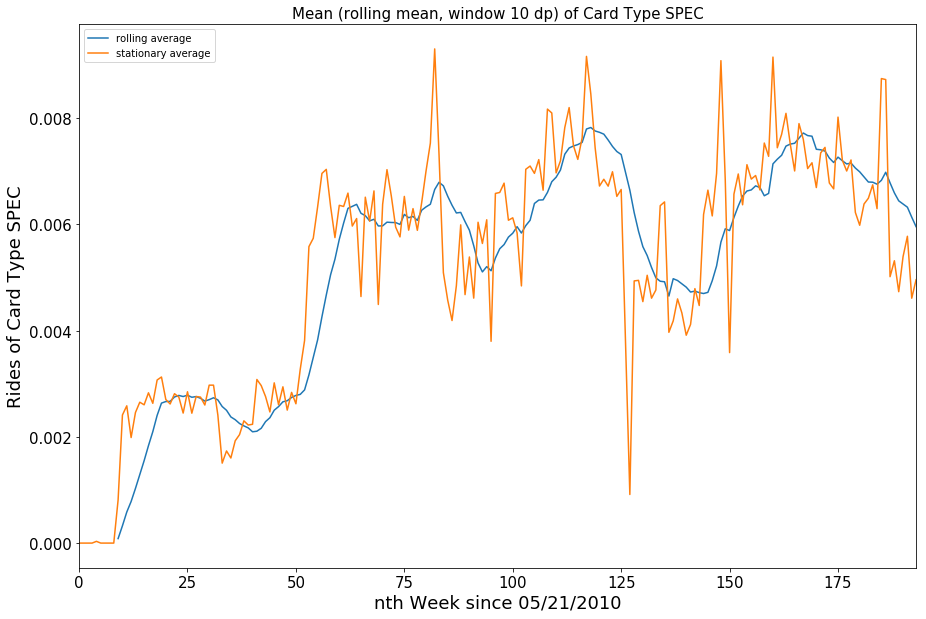

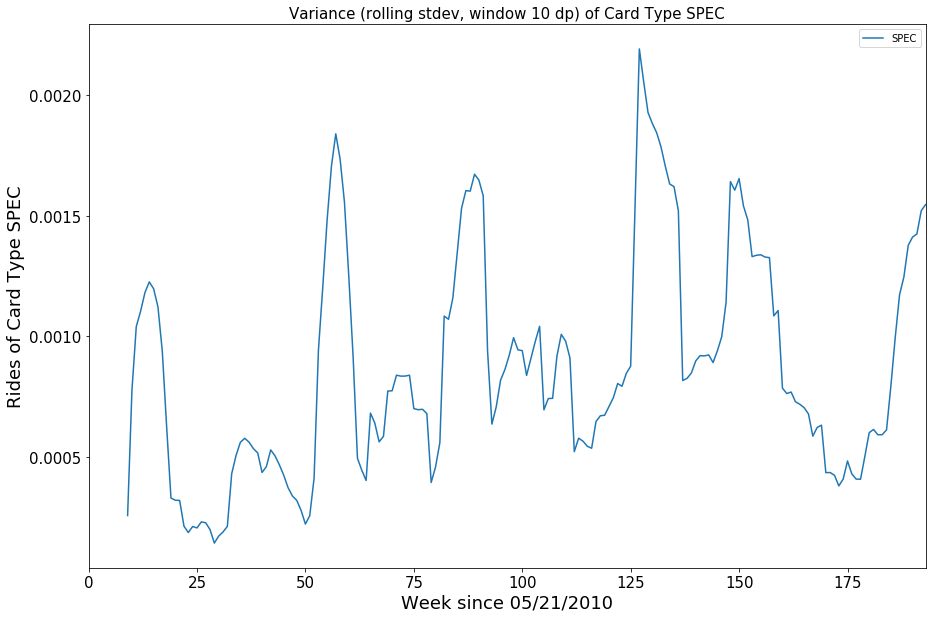

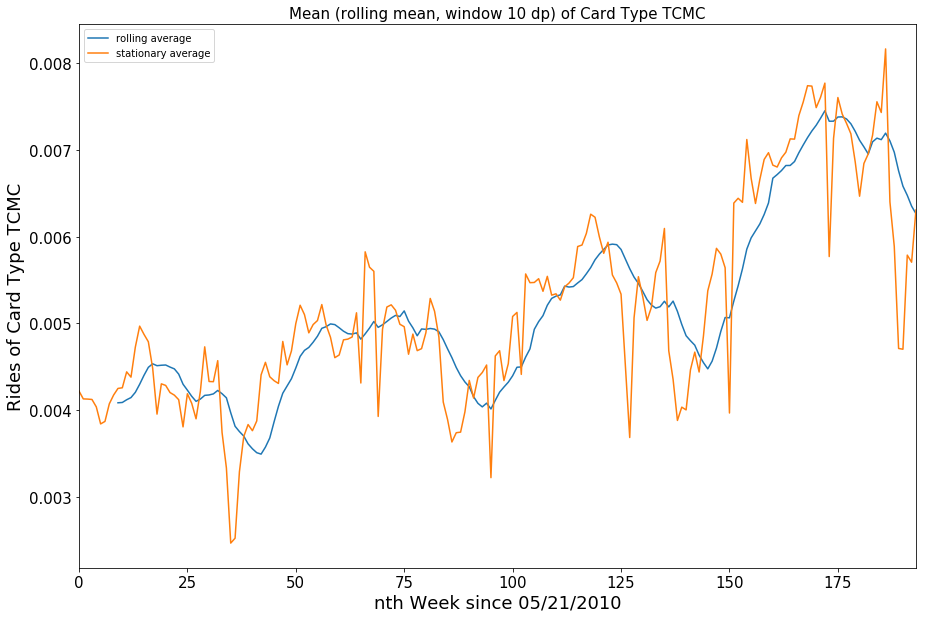

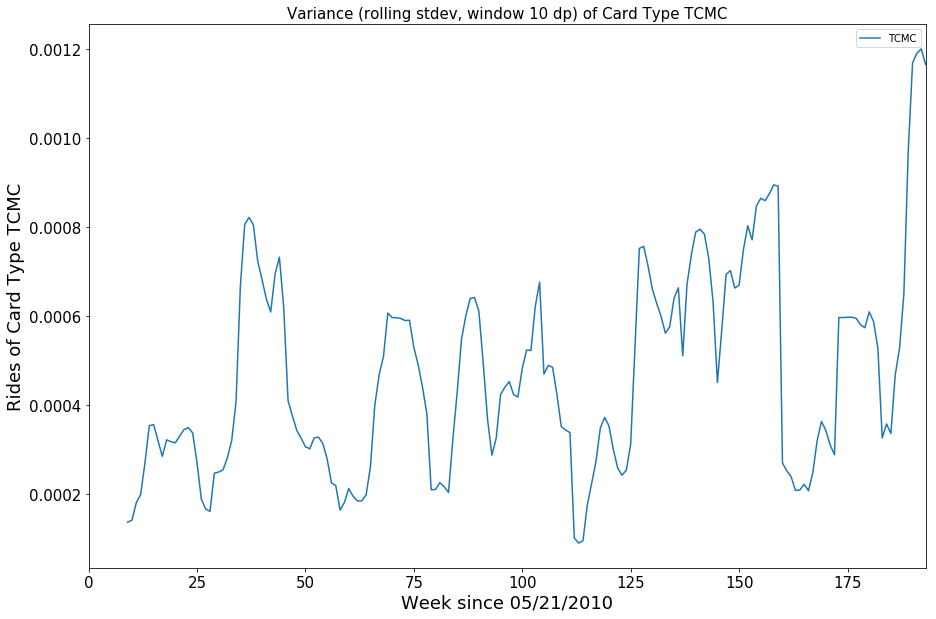

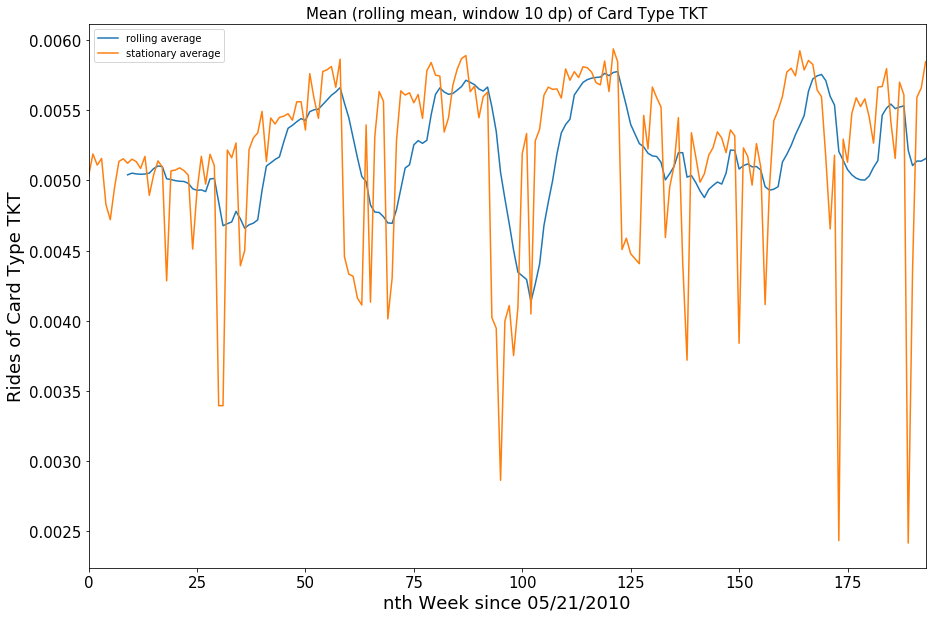

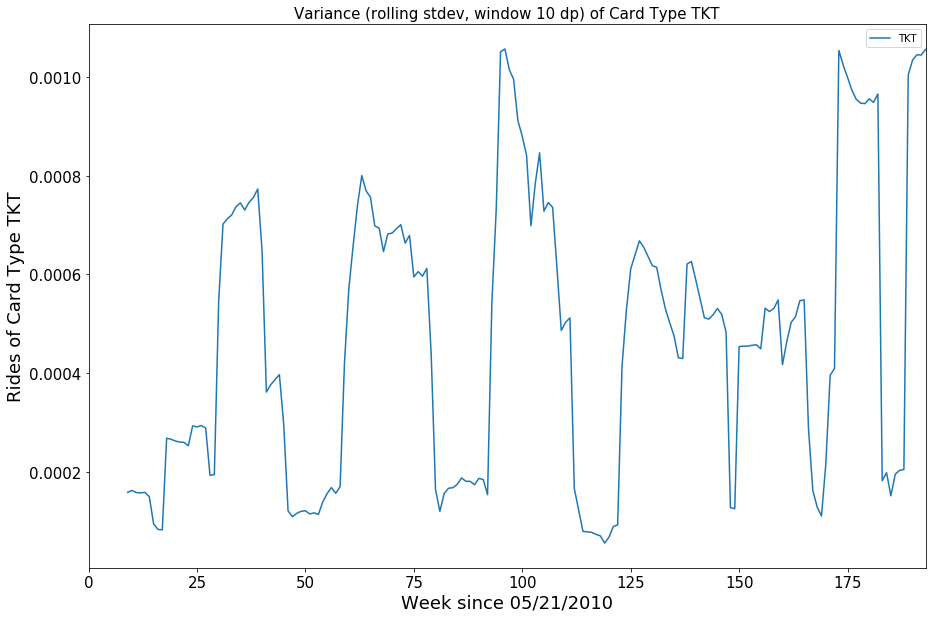

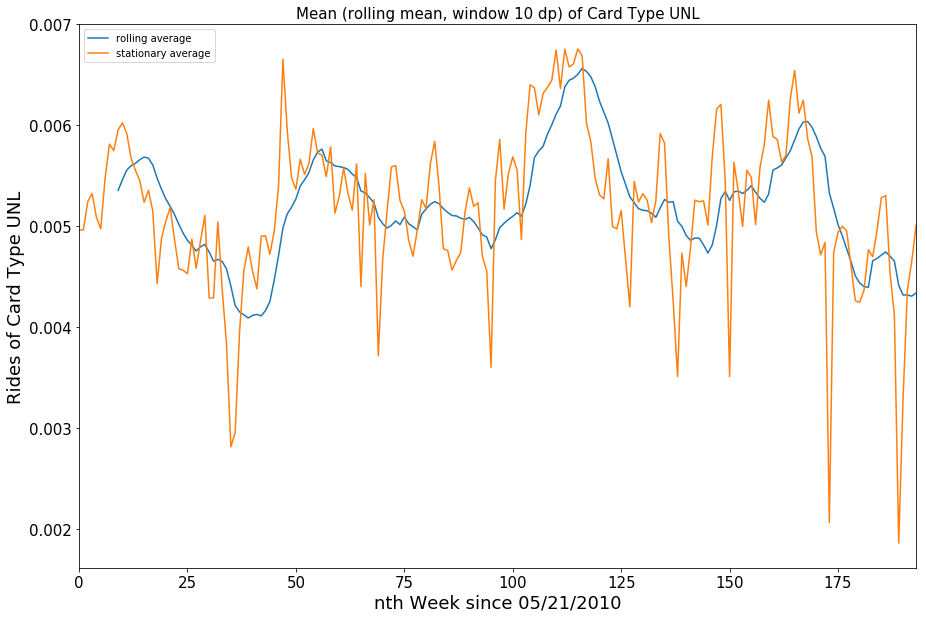

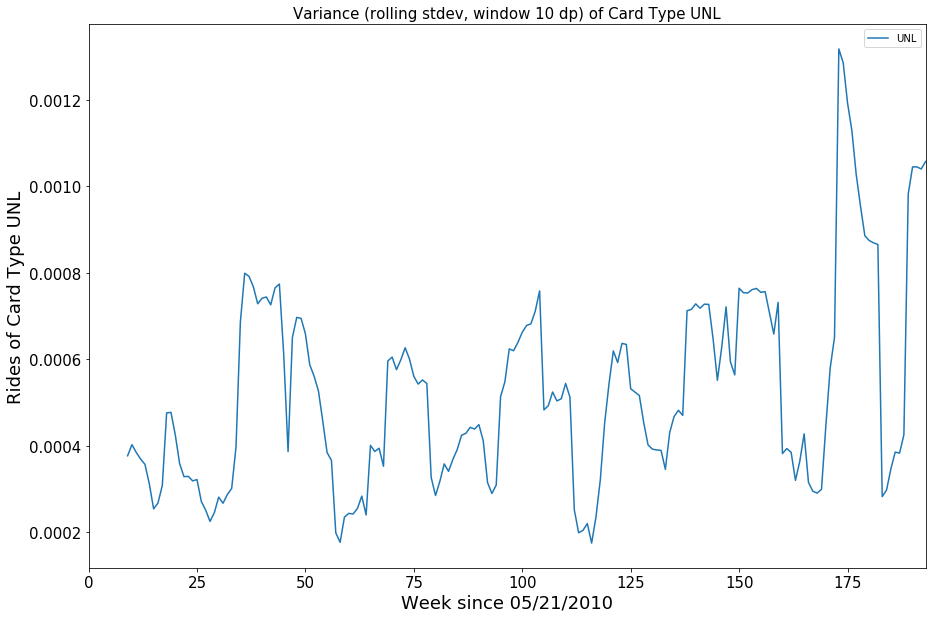

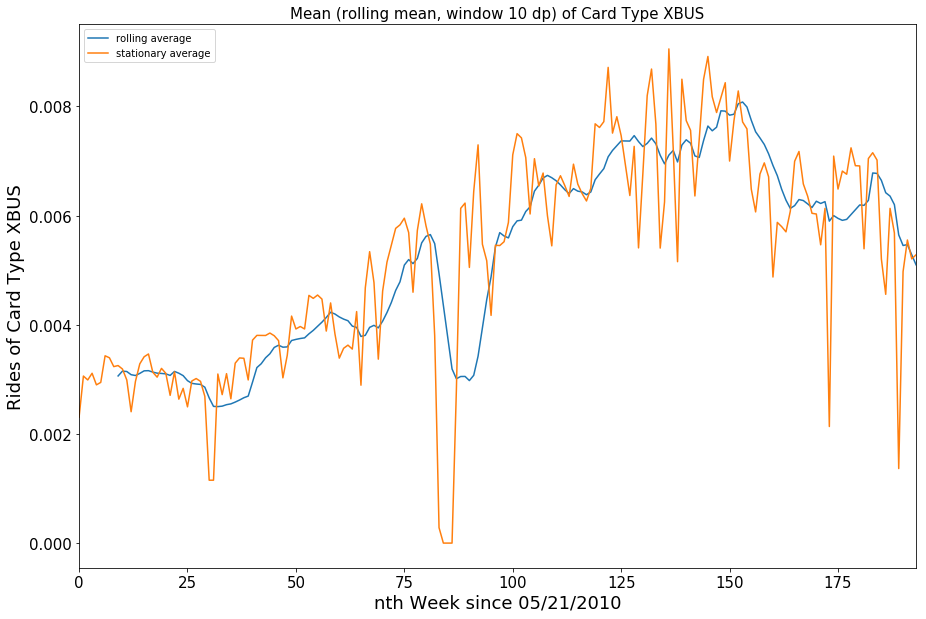

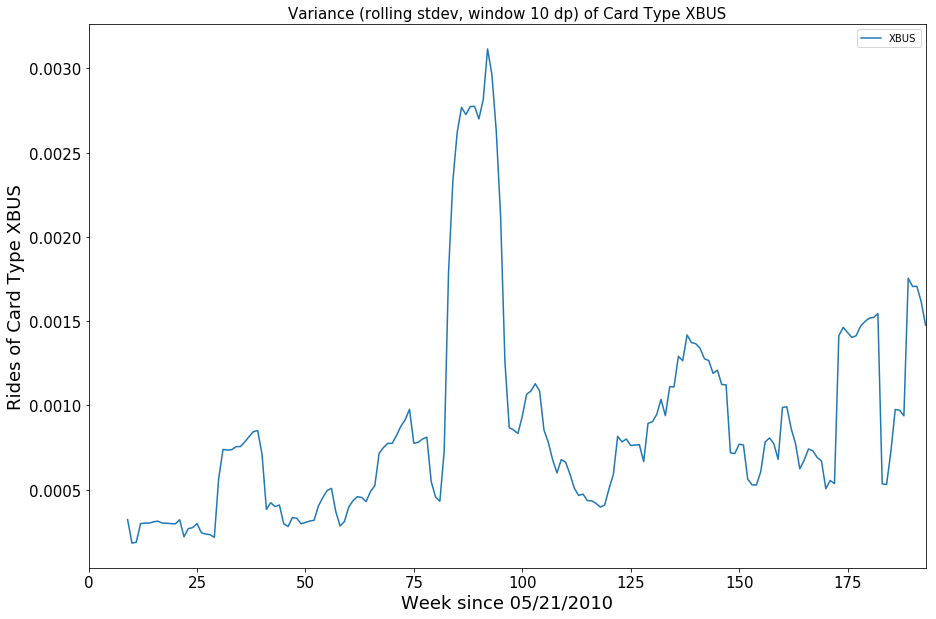

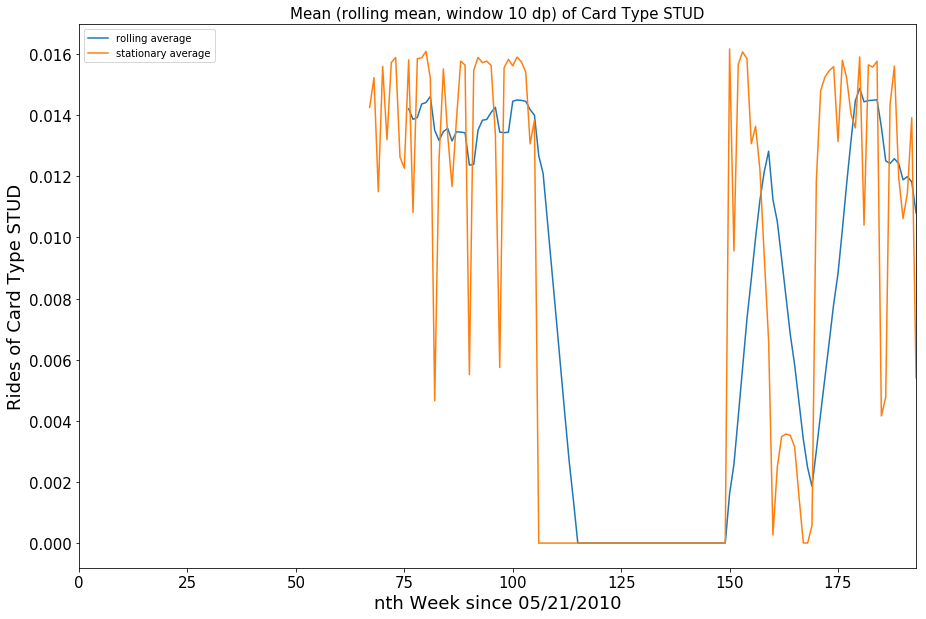

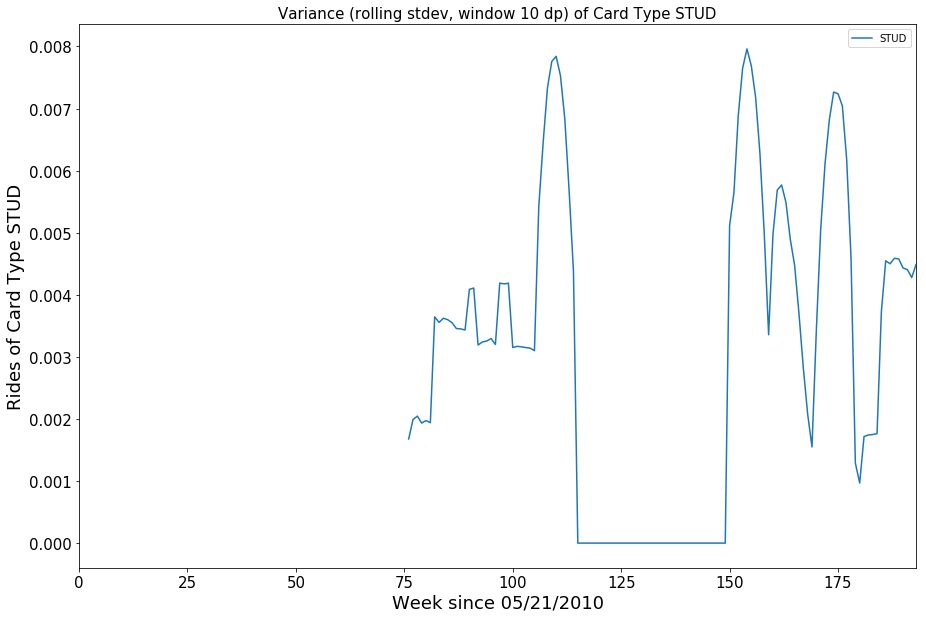

In [41]:
for i in card:   
    fig = pl.figure(figsize=(15,10))
    ax = pd.rolling_mean(df1[i]/df1[i].sum(), 10).plot(figsize=(15,10), fontsize=20, label = "rolling average")
    ax.set_title("Mean (rolling mean, window 10 dp) of Card Type %s" % i, fontsize=15)
    pl.xlabel("nth Week since 05/21/2010", fontsize=18)
    pl.ylabel(("Rides of Card Type %s" % i), fontsize=18)
    pl.xticks(fontsize = 15)
    pl.yticks(fontsize = 15)
    ax.plot(df1[i]/df1[i].sum(), label="stationary average")
    pl.legend(loc = 2)
    
    fig = pl.figure(figsize=(15,10))
    ax = pd.rolling_std(df1[[i]]/df1[[i]].sum(), 10).plot(figsize=(15,10))
    ax.set_title("Variance (rolling stdev, window 10 dp) of Card Type %s" % i, fontsize=15)
    pl.xlabel("Week since 05/21/2010", fontsize=18)
    pl.ylabel(("Rides of Card Type %s" % i), fontsize=18)
    pl.xticks(fontsize = 15)
    pl.yticks(fontsize = 15)

### Above plots have shown the stationary vs rolling average of rides in a 10-day window, and the rolling variance according to each card type. Steady downward trends are seen for card types in: AFAS, EXP, EZ, MTHLY and RFM. Steady upward trends are seen for card types in: 14D, 7D, MR, RR, SEN, SPEC, TCMC, XBUS.

In [72]:
for i in card:
    flux = (df1[i]/df1[i].sum()).rolling(window=10, center=False).mean()
    fluxRatio = flux[9] / flux[-1:]
    print ("the flux ratio of {} is {:.2f}".format(i, float(fluxRatio.values)))

the flux ratio of 10T is 0.98
the flux ratio of 14D is 0.80
the flux ratio of 1D is 0.90
the flux ratio of 2T is 1.07
the flux ratio of 30D is 0.97
the flux ratio of 7D is 0.72
the flux ratio of ADA is 1.11
the flux ratio of AFAS is 4768.56
the flux ratio of EXP is 93458.22
the flux ratio of EZ is 665116.36
the flux ratio of FF is 1.22
the flux ratio of MC is 0.82
the flux ratio of MR is 0.00
the flux ratio of MTHLY is 1.73
the flux ratio of RFM is 1.54
the flux ratio of RR is 0.39
the flux ratio of SEN is 0.34
the flux ratio of SPEC is 0.01
the flux ratio of TCMC is 0.65
the flux ratio of TKT is 0.98
the flux ratio of UNL is 1.23
the flux ratio of XBUS is 0.60
the flux ratio of STUD is nan


Card types such as EXP and EZ have high flux values, probabaly because the services are terminated or substituted by other card types. Card types MR and SPEC may not have been started yet. Other than that, card types MTHLY saw the biggest increase and SEN the biggest decrease.

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [49]:
allperiods = [1./194, 1./104, 1./52, 1./26, 1./13, 1./8, 1./4, 1./2]

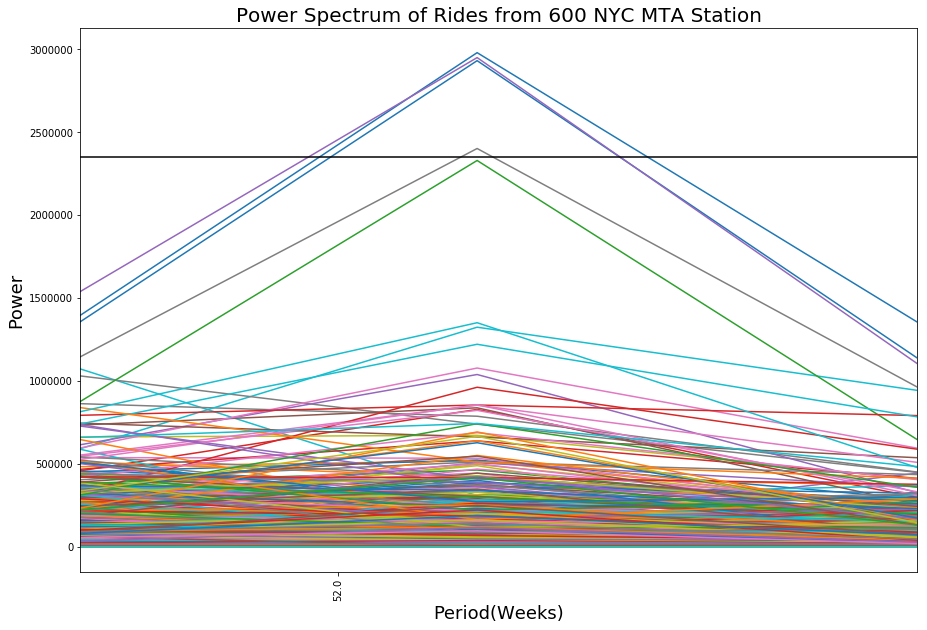

In [48]:
index = []
fig = pl.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(len(sum_swipe)):
    f = np.abs(np.fft.rfft(sum_swipe[i]))
    ax.plot(np.fft.rfftfreq(len(date), 1.0)[1:], (f[1:]))
    if f[4] > 2.35e6:
        index.append(i)
ax.plot((1./60, 1./40), (2.35e6, 2.35e6), 'k-')
ax.set_xticks(allperiods)
ax.set_xticklabels([ "%s"%(1/x) for x in allperiods], rotation=90)
ax.set_xlim(1./60, 1./40)
ax.set_xlabel('Period(Weeks)', fontsize = 18)
ax.set_ylabel('Power', fontsize = 18)
ax.set_title('Power Spectrum of Rides from 600 NYC MTA Station', fontsize = 20)

### Fig shows the power spectrum. It plots the absolute value of the fourier transform. This is to help visualize the 1-year period peak

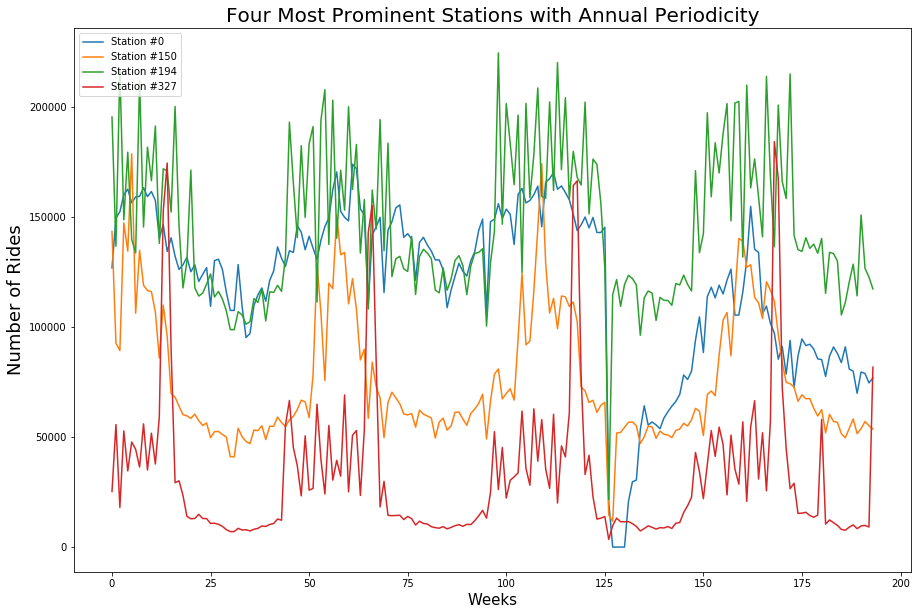

In [53]:
pl.figure(figsize=(15,10))
for i in index:
    pl.plot(sum_swipe[i], label='Station #%s'%i)
pl.xlabel('Weeks', fontsize=15)
pl.ylabel('Number of Rides', fontsize=18)
pl.title('Four Most Prominent Stations with Annual Periodicity', fontsize=20)
pl.legend(loc = 2)

### Figure shows the top four stations with an annual periodicity. There is high ridership during summer and fall and drops down during winter. One explanation could be that these stations are located near summer vacation spots like water parks or beaches etc. 

In [57]:
date[48:70]

DatetimeIndex(['2011-05-01', '2011-05-08', '2011-05-15', '2011-05-22',
               '2011-05-29', '2011-06-05', '2011-06-12', '2011-06-19',
               '2011-06-26', '2011-07-03', '2011-07-10', '2011-07-17',
               '2011-07-24', '2011-07-31', '2011-08-07', '2011-08-14',
               '2011-08-21', '2011-08-28', '2011-09-04', '2011-09-11',
               '2011-09-18', '2011-09-25'],
              dtype='datetime64[ns]', freq='W-SUN')

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 

In [58]:
tots = mta_data.transpose(2,0,1).reshape(mta_data.shape[2], mta_data.shape[1]*mta_data.shape[0]).T

In [60]:
tots = tots[tots.std(1)>0]
value = ((tots.T - tots.mean(1))/tots.std(1)).T

In [62]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    #plt.title('Elbow for KMeans clustering')
    plt.show()

In [67]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7]


for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = clusterer.fit_predict(value)
    silhouette_avg = silhouette_score(value, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(value, cluster_labels)


('For n_clusters =', 2, 'The average silhouette_score is :', 0.28792444716843063)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.26446983137207097)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.24871854286430131)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.20589464728780069)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.21544699548496252)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.21404880477771118)


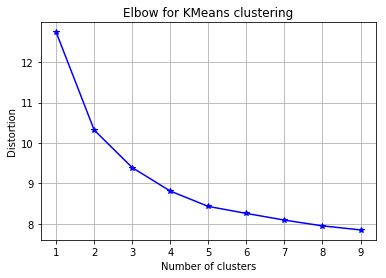

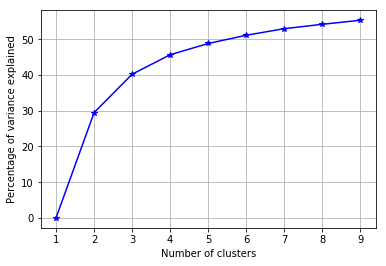

In [66]:
#elbow
elbow(value,range(1,10))

2 clusters seem to be optimum based on silhoutte score and elbow curve even though it explains only 30% variance

In [68]:
km = KMeans(n_clusters=2).fit(value)
cluster_label = km.predict(value)

In [69]:
from sklearn.decomposition import PCA
n = value.shape[1]
pca = PCA(n)
Xproj = pca.fit_transform(value)

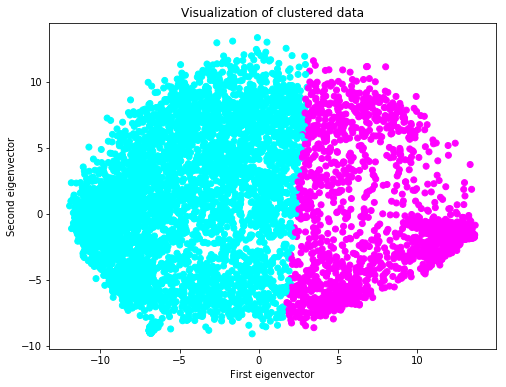

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=cluster_label, cmap=plt.cm.cool)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.title("Visualization of clustered data")
plt.show()

### Fig shows the clustered data visualized using PCA